# Part 1

In [1]:
# This cell consists a set of useful imports. Feel free to modify if you need anything else or would like
# remove a redundant import.

import numpy as np
from scipy.ndimage import gaussian_filter # This filter will be used to generate the smoothed model
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver, plot_velocity
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Reduce the level of output printed by Devito
from devito import configuration
configuration['log-level'] = 'WARNING'

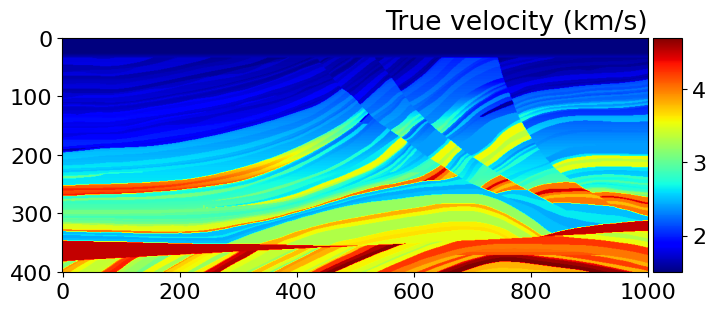

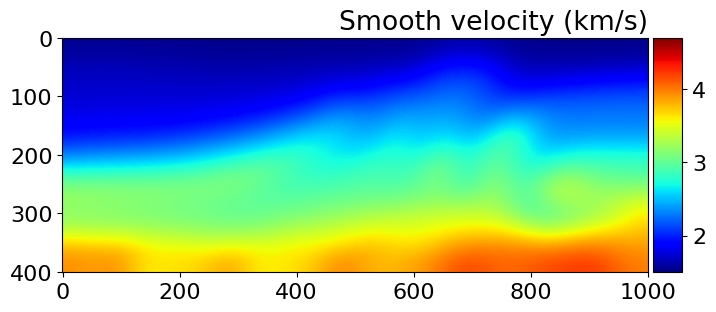

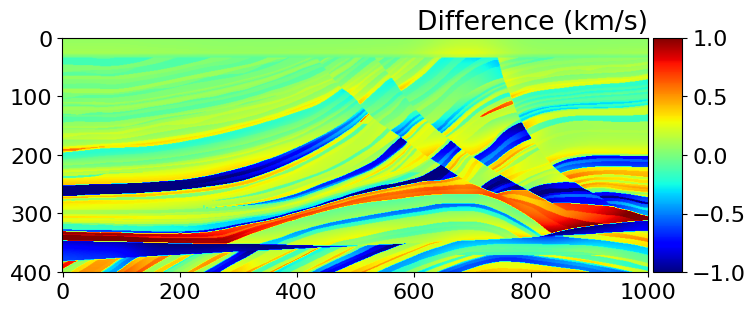

In [2]:
# Load 2D Marmousi velocity model from file
# Note that the data corresponds to the velocity of pressure waves in km/s
v = np.fromfile('data/vp_marmousi_bi', dtype='float32', sep="")

# Re-shape the velocity model v as required by the data
shape = (1601, 401)
spacing = (10., 10.) # physical grid dpacing, (dx, dy), in meters
origin = (0., 0.)
v = v.reshape(shape)

# Cut velocity model size from (1601,401) to (1001,401)
# (This is to speed up the computations a little)
v = v[300:-300, :]

# Gaussian smoothing of the true velocity model
# The 'smothed' version of our velocity model corresponds to something along the lines
# of what an initial guess may look like in a 'real' scenario
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#Plot true & smooth Vp models, and their difference
from examples.seismic import plot_image
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Smooth velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Difference (km/s)', loc='right')
plot_image(v_sm-v, vmin=-1.0, vmax=1.0, cmap="jet")

## Add part 1 solution below

Ensure comments are added where necessary.

**1. Create suitable Devito Model objects.**

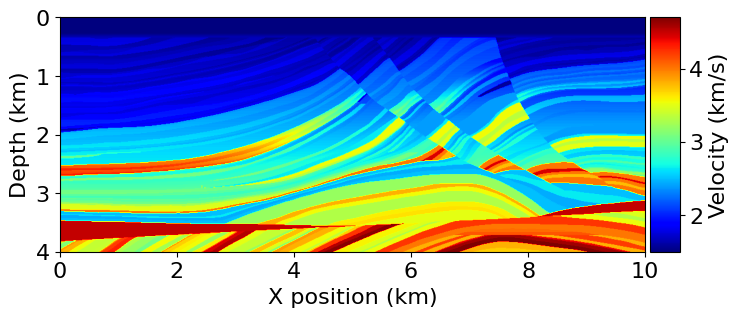

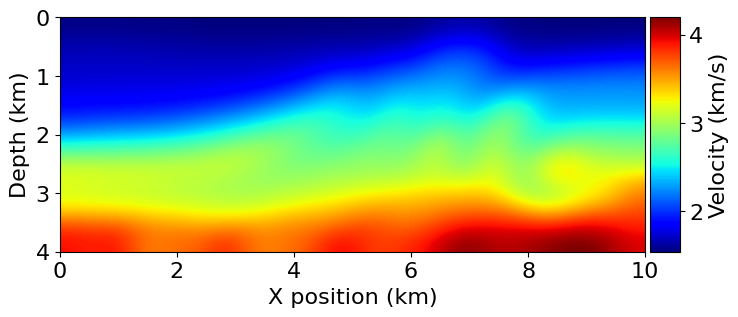

In [3]:
# Creating True Velocity Model
model = Model(vp=v, origin=origin, shape=v.shape, dtype=np.float32,
                   spacing=spacing, space_order=4, bcs="damp", nbl=45)

# Creating Smooth Velocity Model
model0 = Model(vp=v_sm, origin=origin, shape=v_sm.shape, dtype=np.float32,
                     spacing=spacing, space_order=4, bcs="damp", nbl=45,
                     grid=model.grid)

plot_velocity(model)
plot_velocity(model0)

**2. Devise and plot an aquisition geometry for the domain.**

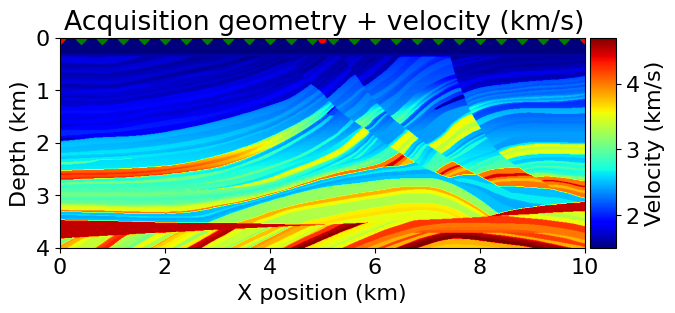

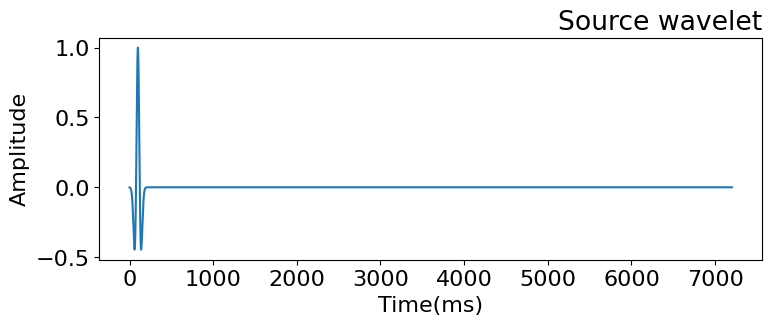

In [4]:
#set source number = 3, and receiver number = 101
nsrc=3; nrcv=101;

#set 3 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc)
src_loc[:, 1] = 20.

#set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 20.

t0 = 0.     # Start time
tn = 7200.  # End time
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

# Plot acquisition geometry overlaid with true Vp, and source wavelet
from examples.seismic.plotting import plot_velocity
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.subplot(2,1,1); 
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model, source=src_loc, receiver=rcv_loc[::4]); 

plt.subplot(2,1,2); 
plt.title('Source wavelet', loc='right')
plt.plot(geom_all.src.time_values, geom_all.src.data[:, 0])
plt.xlabel('Time(ms)')  
plt.ylabel('Amplitude')  
plt.tight_layout(); 
plt.show()


**3. Plot the shot records and their differences.**

In [5]:
#Rewrite the plot_shotrecord function to fit the task
def plot_shotrecord(rec, model, t0, tn, ax=None, colorbar=True):
    if ax is None:
        ax = plt.gca()
    
    scale = np.max(rec) / 10.
    extent = [model.origin[0], model.origin[0] + model.domain_size[0]*1e-3, tn*1e-3, t0*1e-3]

    plot = ax.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent, aspect='auto')
    ax.set_xlabel('X position (km)')
    ax.set_ylabel('Time (s)')

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)


In [6]:
#Pick one source number
isrc = 3
geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                               t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=4)

#Define forward modeling of one source
def modeling_1src(vp_in, isrc):
    # Update acquisition geometry based on source location
    geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:], t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(model, geometry, space_order=4)

    # Create Receivers
    d_obs = Receiver(name='d_obs', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)

    # Calculate simulate data from true model
    _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
    # Calculate simulate data from smooth model
    _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

    return d_obs, d_syn


Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on ph

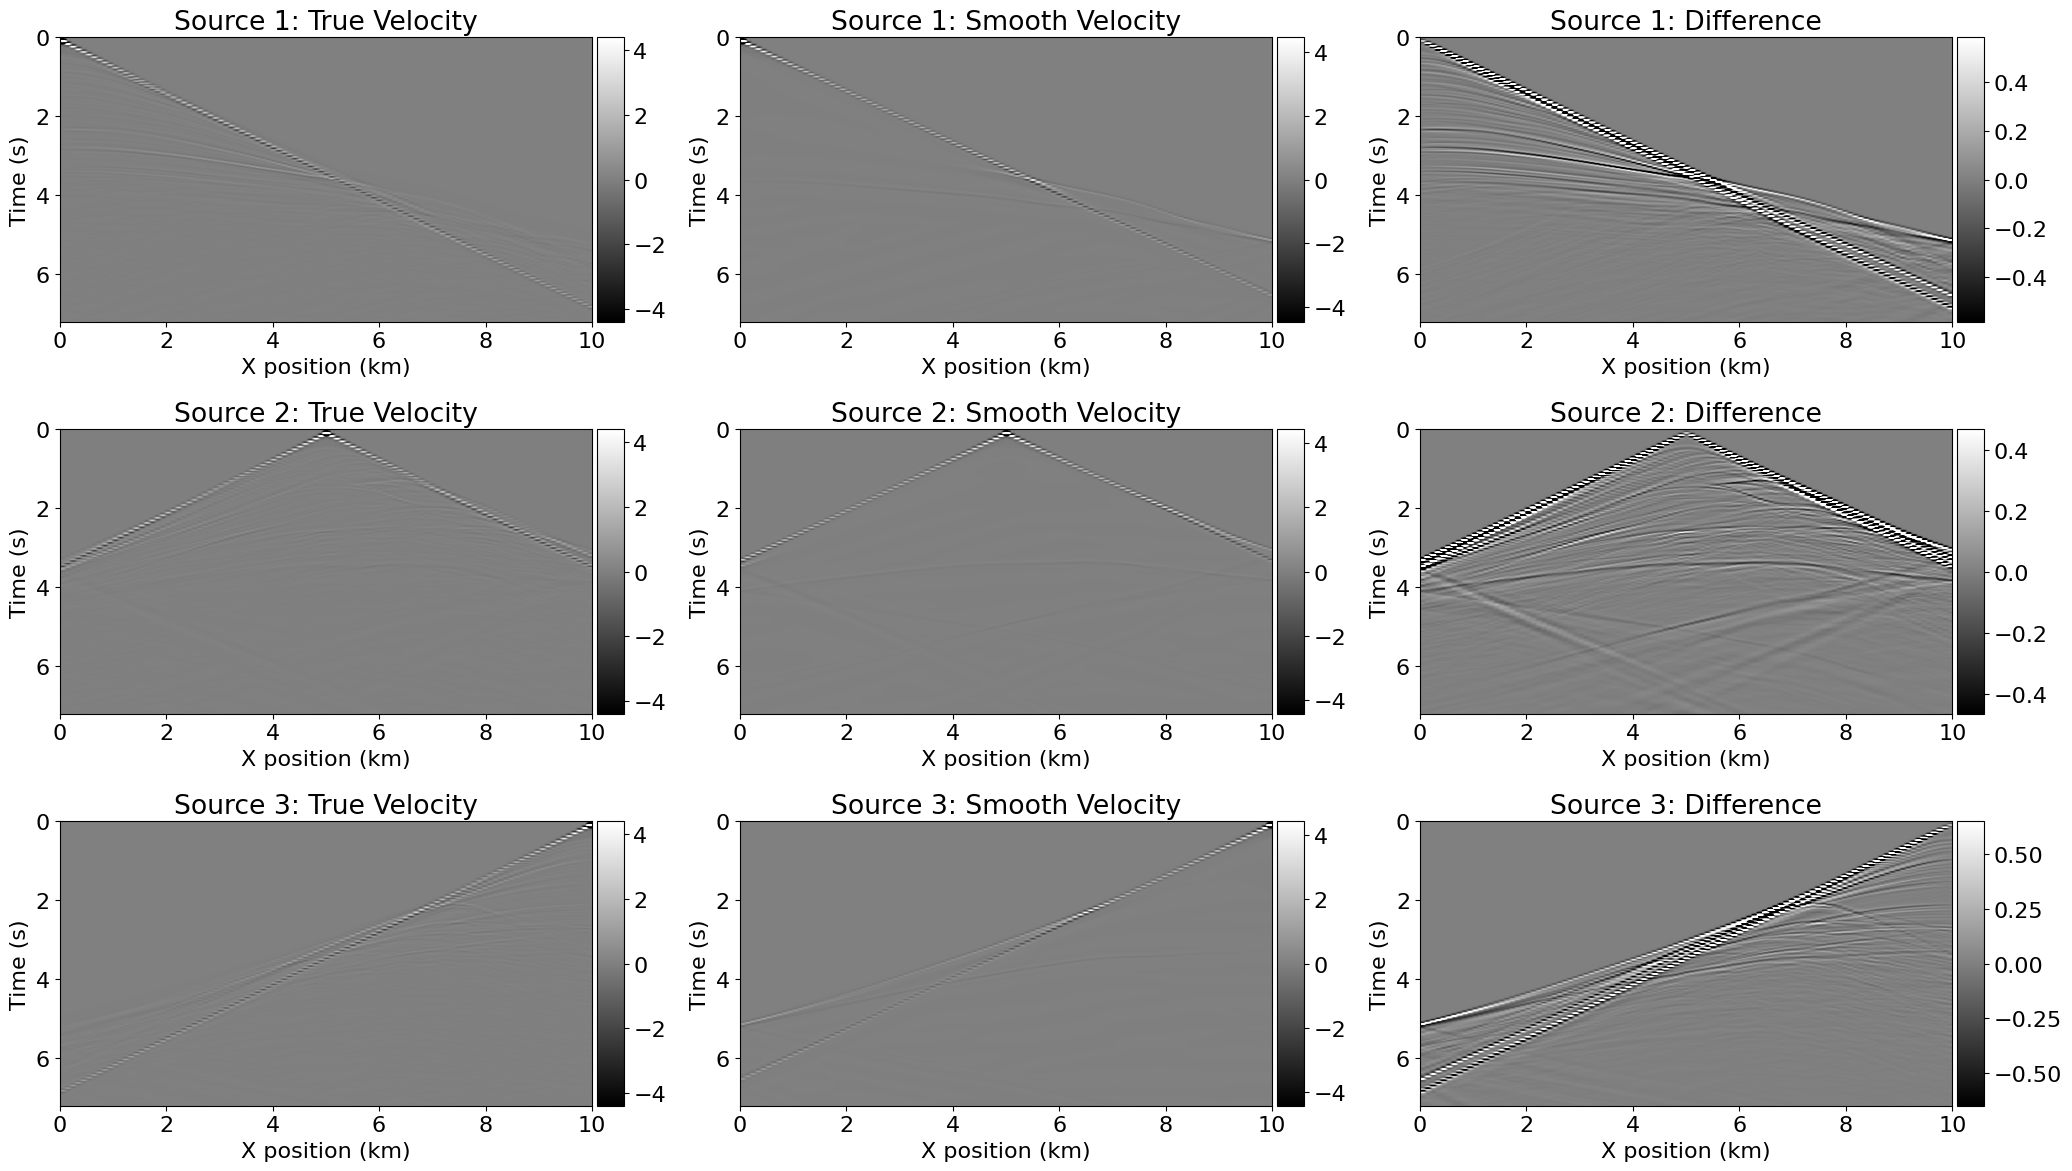

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(21, 12))  # Grid with 3 rows and 3 columns

for i, isrc in enumerate([1, 2, 3]):
    
    record, record0 = modeling_1src(model0.vp, isrc)  

    # True shot record
    plot_shotrecord(record.data, model, t0, tn, ax=axs[i, 0], colorbar=True)
    axs[i, 0].set_title(f'Source {isrc}: True Velocity')
    
    # Smooth shot record
    plot_shotrecord(record0.data, model, t0, tn, ax=axs[i, 1], colorbar=True)
    axs[i, 1].set_title(f'Source {isrc}: Smooth Velocity')
    
    # Difference
    diff = record0.data - record.data
    plot_shotrecord(diff, model, t0, tn, ax=axs[i, 2], colorbar=True)
    axs[i, 2].set_title(f'Source {isrc}: Difference')

plt.tight_layout()
plt.show()


**4. Discuss and justify the choices made in parts 2 and 3.**

- **Choice regarding the number of boundary layers(nbl):** The number of boundary layers usually depends on the wavelength ($\lambda$) of the boundary layer to ensure effective absorption of boundary reflections.We should consider the minimum velocity of the wave in the medium, for a minimum wave velocity of 1500m/s and a frequency of 10 Hz, at a wavelength of $\lambda$ = 150m($\lambda= c/f$). Ideally, the thickness of the boundary layer should cover at least a few wavelengths in order to ensure that the boundary reflections are absorbed efficiently. If we take 3 wavelengths as a reference: boundary layer thickness = 3 × 150m = 450m. Given that the size of each grid is 10mx10m, we need to convert the thickness of the boundary layer to the number of grid cells. Divide the thickness of the boundary layer by the size of the individual grids: nbl = 450m/10m = 45.

- **Choices regarding the end time of the simulation:** Based on the given minimum wave speed of 1.5 km/s and model size of 4kmx10 km, the simulation end time should be approximately 7.18s ($d=vt$). This time is calculated based on the time it takes for the wave to cross the model diagonal (the longest possible path) at the lowest speed, ensuring that the wave can propagate from either location to any other location in the model. To ensure that all relevant wave events are captured, we increase the simulation time slightly, setting it to 7.2s (7200ms). It can be observed from the shot images we have drawn that we have successfully captured the complete path of the wave to reach its deepest depths, which means that the end time we have set is reasonable.

- **Choices regarding the Ricker source peak frequency:** Higher frequencies and shorter wavelengths theoretically provide better spatial resolution. However, high-frequency waves decay more rapidly during propagation and may not be effective in reaching deep targets. The type of subsurface medium also affects the choice of frequency. If the medium attenuates high-frequency waves very strongly, it may be necessary to select a lower frequency to ensure that the waves reach the target depth. For a model with a depth of 4 km, we chose a frequency of 10 Hz to obtain sufficient depth of penetration and reasonable resolution.

- **Explain the positioning of the sources and receivers:** Source and receiver settings directly affect the coverage, quality, and ultimately the accuracy of the interpretation of the data. The number of sources is limited to three, evenly distributed across the top of the model, to capture as much information as we need while minimizing the sources' interference with each other. The receivers were arranged uniformly on the surface of the model to record the signals from the waves emitted from the sources after they were reflected or refracted by the subsurface structure. The total number of receivers was set to 101, which is sufficient to cover the entire detection area and to be able to record enough reflected wave information for subsequent data processing and interpretation.

- **Discuss the shot records generated:** The shot records show wavefield data recorded by an array of receivers after waves emanating from a seismic source have been reflected or refracted by a subsurface structure. Analysis of the shot record can provide important information about the subsurface structure and help to evaluate the effectiveness of the acquisition geometry.
    - **Direct Arrivals:** Represents the path of wave propagation directly from the source to the receiver.The presence of direct arrivals verifies that the direct path between the source and receiver is open, but they contribute less to the interpretation of the subsurface structure. Our shot records show that we successfully captured complete direct waves from each source.
    - **Reflections:** Reflected waves are the most important part of the shot record because they carry information about the subsurface interface. The arrival time, intensity and waveform of reflected waves can reveal depth, dip and physical differences in the formation. Our shot records have also been successful in recording some reflected waves that are not very clear.
    - **Refracted Waves:** Under certain conditions, shot records may also capture refracted waves, which are refracted at the stratigraphic interface and reach the receiver. Refracted waves can provide information on the velocity structure of the subsurface, especially in deeper formations.

The ideal acquisition geometry should be able to capture reflected waves from multiple directions and depths to fully reveal the three-dimensional properties of the subsurface structure. The continuity and intensity of reflected waves in the shot record can reflect the effective coverage of the acquisition geometry. The quality and characterization of the data generated from the shot records show that we are able to observe clear direct and partially reflected waves as well as refracted waves with a wide range of coverage, which indicates that our chosen acquisition geometry is basically reasonable.